In [59]:
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import utils
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile
import csv

In [3]:
# Loading the text file coded - each order as a sentence contaings product_ids as words.

with open('data_products.txt') as f:
    text = f.read()

In [4]:
words = text.split()
print(words[:30])

['23734', '15422', '4932', '46361', '20114', '13129', '5031', '2447', '28931', '<period>', '13129', '28931', '20114', '15422', '5031', '2447', '23734', '4932', '46361', '<period>', '5031', '23734', '4932', '13129', '46361', '15422', '2447', '20114', '28931', '<period>']


Senences (orders) are delimited by period

In [5]:
print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words: 106948089
Unique words: 49678


There are 106948089 words each representing a product_id bought in any order. There are 49678 unique orders.

Here, I'm creating dictionaries to covert words to integers and backwards, integers to words. The integers are assigned in descending frequency order, so the most frequent word ("the") is given the integer 0 and the next most frequent is 1 and so on. The words are converted to integers and stored in the list `int_words`.

In [6]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

In [7]:
dictionary={}
with open('products.csv', encoding = 'utf8') as csvfile:
    a = csv.reader(csvfile, delimiter=',')
    for i,row in enumerate(a):
        if row[0] in dictionary.keys():
            list_of_products=dictionary[row[0]]
            list_of_products.append(row[1])
            dictionary[row[0]]=list_of_products
        else:
            dictionary[row[0]]=[row[1]]

In [8]:
del dictionary['product_id']

## Making batches

In [9]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    b = list(words[start:idx])
    p = list(words[idx+1:stop+1])
    
    while '<period>' in b:
        i = b.index('<period>')
        b = list(b[i+1:])
        
    while '<period>' in p:
        j = p.index('<period>')
        p = list(p[:j])
    
    
    target_words = set(b+p)
    
    return list(target_words)

In [10]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            if batch[ii] != '<period>':
                batch_x = batch[ii]
                batch_y = get_target(batch, ii, window_size)
                y.extend(batch_y)
                x.extend([batch_x]*len(batch_y))
        yield x, y
    

In [11]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None, None], name='labels')

## Embedding



In [12]:
n_vocab = len(int_to_vocab)
n_embedding = 280 # Number of embedding features 
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs)

## Negative sampling



In [13]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, 
                                      labels, embed,
                                      n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

## Validation

In [14]:
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [20]:
epochs = 1
batch_size = 1000
window_size = 7

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 1000 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/1000),
                      "{:.4f} sec/batch".format((end-start)/1000))
                loss = 0
                start = time.time()
            
            if iteration % 5000 == 0:
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/products.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/1 Iteration: 1000 Avg. Training loss: 3.1092 0.0588 sec/batch
Epoch 1/1 Iteration: 2000 Avg. Training loss: 2.1727 0.0573 sec/batch
Epoch 1/1 Iteration: 3000 Avg. Training loss: 2.0486 0.0577 sec/batch
Epoch 1/1 Iteration: 4000 Avg. Training loss: 1.9639 0.0577 sec/batch
Epoch 1/1 Iteration: 5000 Avg. Training loss: 1.9238 0.0579 sec/batch
Nearest to 20114: 35718, 48722, 25006, 1515, 15265, 41966, 35938, 31608,
Nearest to 27156: 13602, 16756, 39243, 4059, 10674, 461, 44001, 9739,
Nearest to 27845: 2813, 34770, 18871, 9353, 20697, 39934, 34117, 3661,
Nearest to 8277: 46056, 2948, 8006, 8706, 29804, 32051, 12773, 36898,
Nearest to 38689: 26862, 31450, 34767, 46095, 27257, 16619, 17558, 35458,
Nearest to 39928: 29586, 18287, 48755, 19076, 4610, 33363, 27378, 8526,
Nearest to 8518: 18178, 26109, 27442, 4895, 25816, 566, 17154, 40323,
Nearest to 47766: 20878, 5703, 21646, 504, 33120, 17189, 9817, 20672,
Nearest to 14147: 34878, 22309, 24831, 20763, 12992, 41782, 32766, 41608,
Neares

Restore the trained network if you need to:

In [ ]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

In [21]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [25]:
dictionary['<period>'] = 'period'

int_to_product = {vocab_to_int[product_id]:dictionary[product_id][0] for product_id in vocab_to_int}

product_to_int = {int_to_product[key]:key for key in int_to_product}

products = pd.read_csv("products.csv")

In [70]:
a = products[products.aisle_id == 112]
b = products[products.aisle_id == 134]

prods1 = list(a.product_id)[:20]
#prods2 = list(b.product_id)[:20]

prods = prods1#+prods2

ints = [vocab_to_int[str(i)] for i in prods]

In [54]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from numpy.random import rand
from pylab import figure

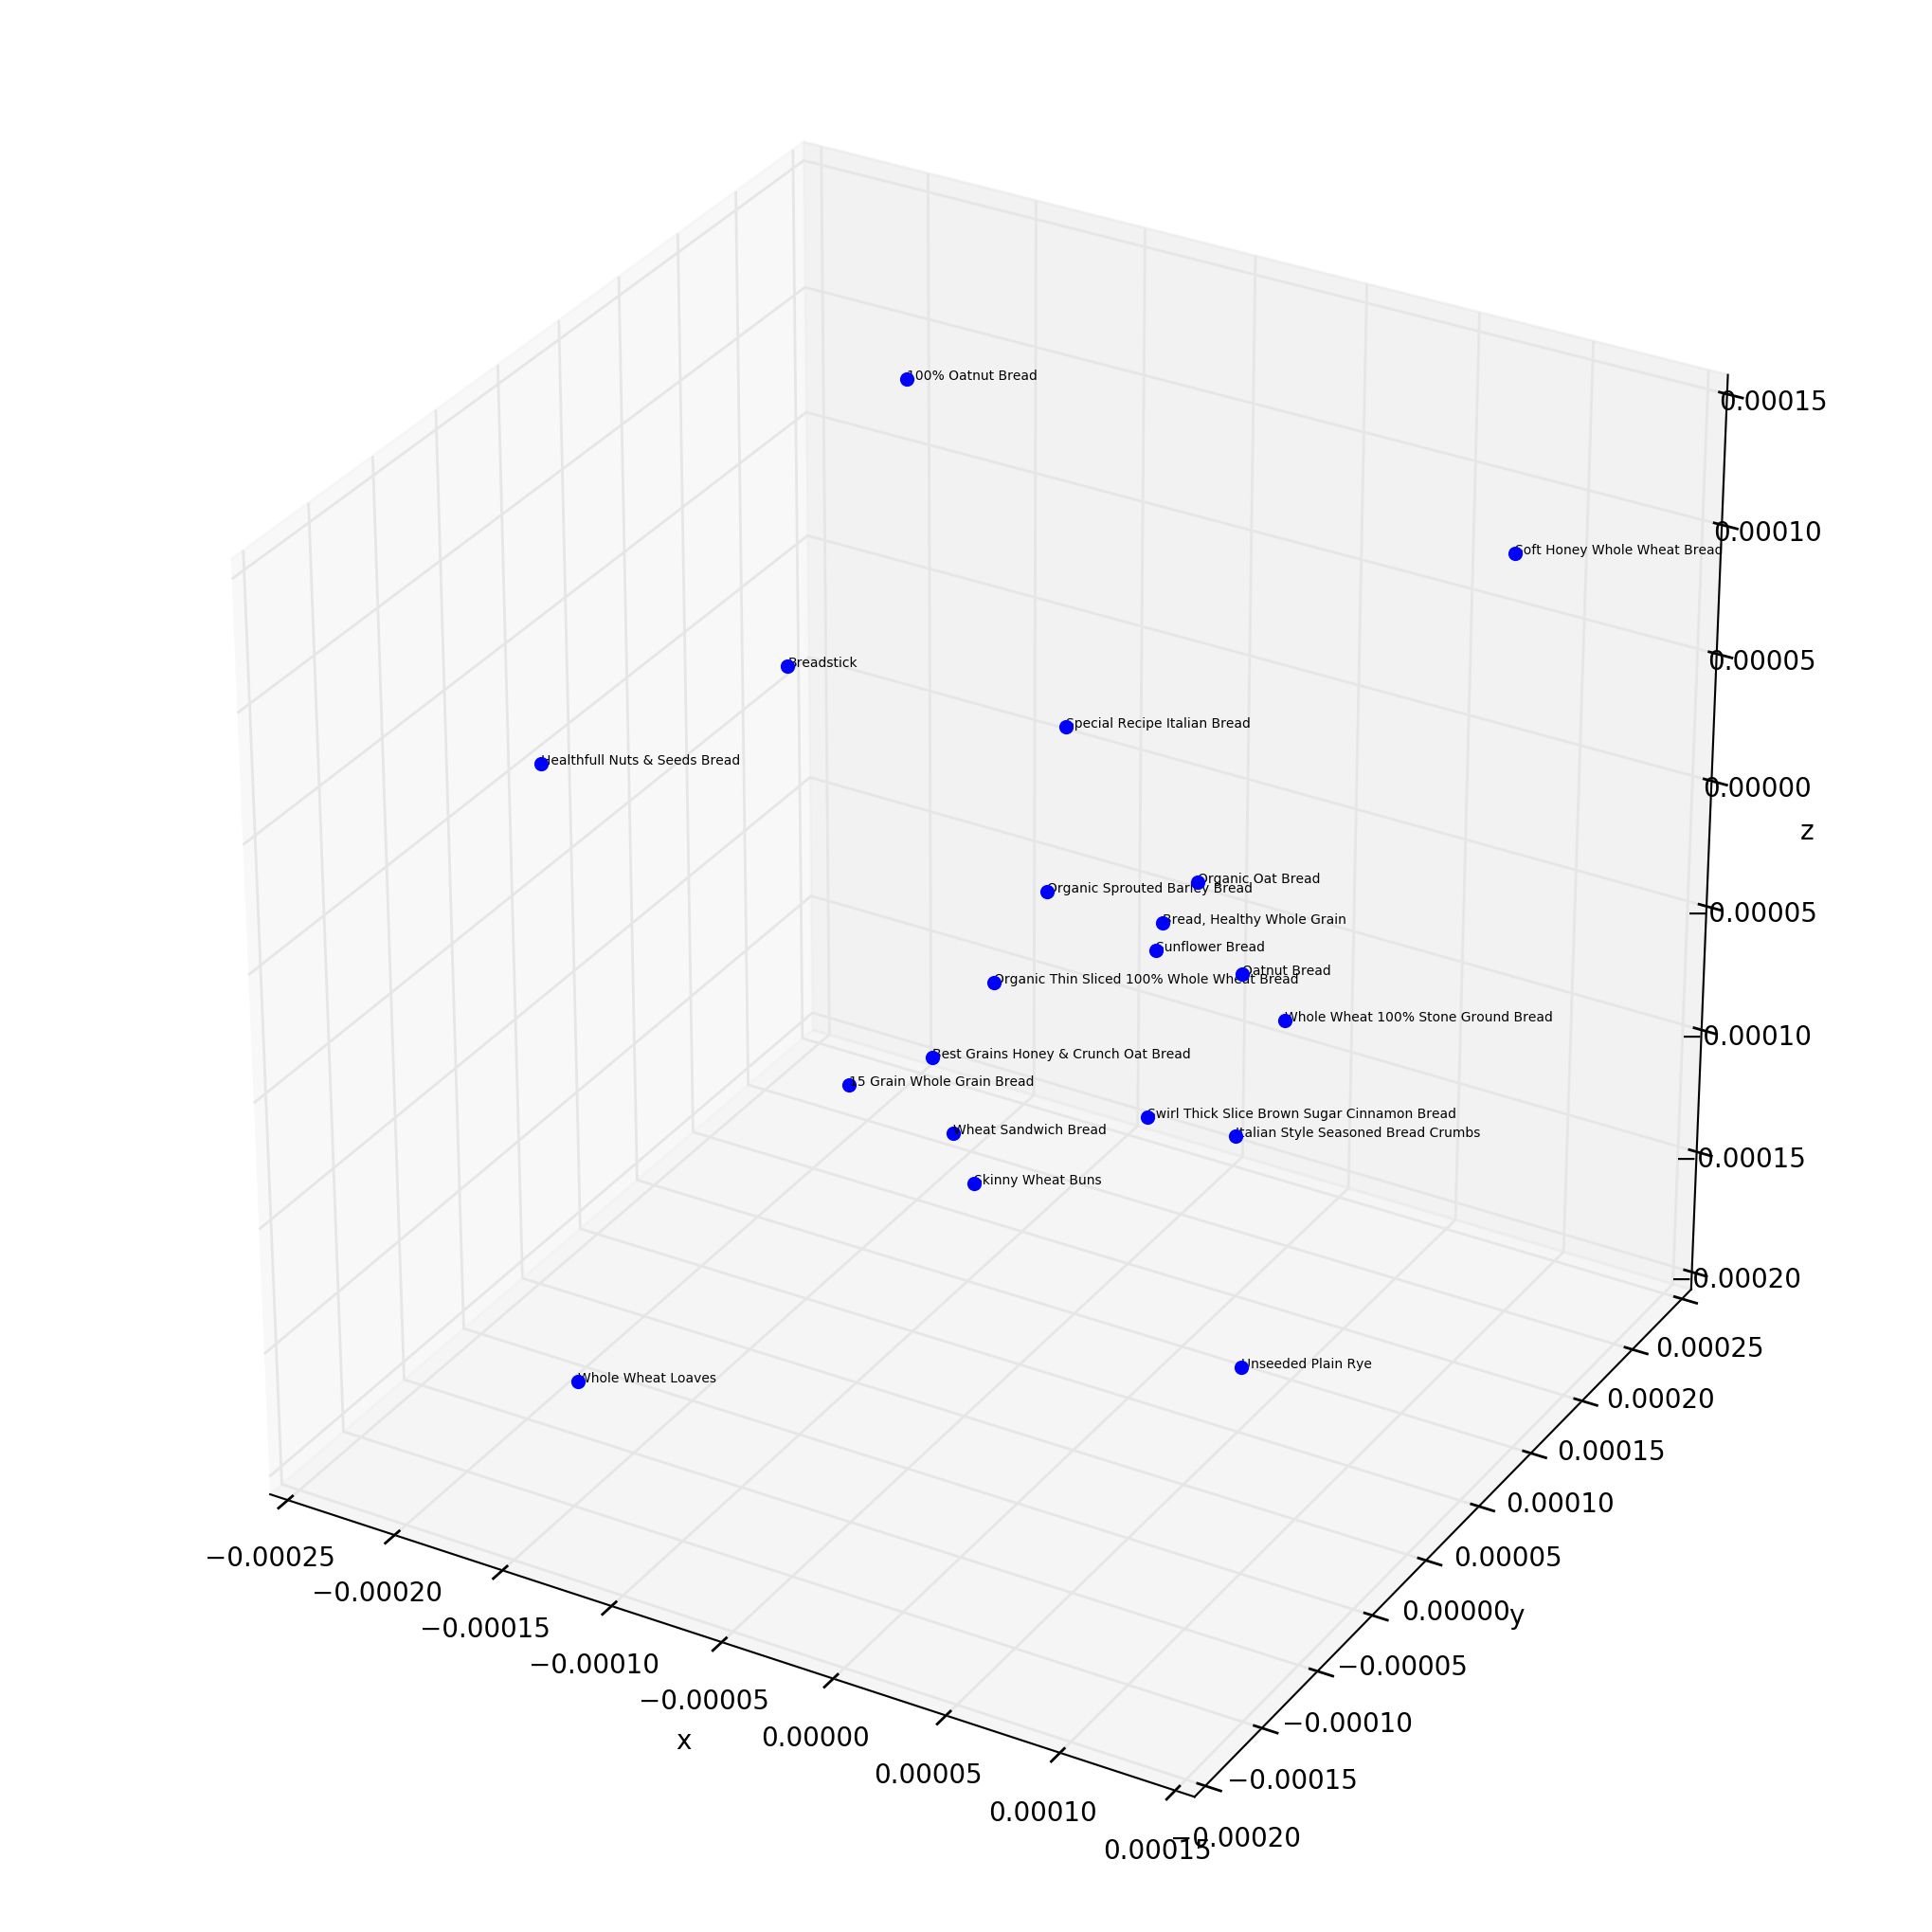

In [71]:
viz_words = 20
tsne = TSNE(n_components = 3)

x = embed_mat[ints]
names = [int_to_product[i] for i in ints]
embed_tsne = tsne.fit_transform(x)

fig = figure(figsize = (10,10))
ax = Axes3D(fig)

for i in range(viz_words): #plot each point + it's index as text above
    ax.scatter(embed_tsne[i,0],embed_tsne[i,1],embed_tsne[i,2],color='b') 
    ax.text(embed_tsne[i,0],embed_tsne[i,1],embed_tsne[i,2],  '%s' % (names[i]), size=5, zorder=1, color='k') 

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
pyplot.show()